In [1]:
!uname -a

Linux compute-0-14.local 2.6.32-642.el6.x86_64 #1 SMP Tue May 10 17:27:01 UTC 2016 x86_64 x86_64 x86_64 GNU/Linux


In [2]:
!pwd

/home/tallam/plasticc/snmachine/examples


In [3]:
!pip install ../.

Processing /home/tallam/plasticc/snmachine
  Running setup.py bdist_wheel for snmachine ... done
  Stored in directory: /tmp/pip-ephem-wheel-cache-msjtfejj/wheels/cd/65/db/fda56ff3f0d6fa8ba1e7b69dab8a17be3a2bbe7940a42d6151
Successfully built snmachine
  Found existing installation: snmachine 1.1.1
    Uninstalling snmachine-1.1.1:
      Successfully uninstalled snmachine-1.1.1


# Notebook for running the snmachine pipeline on PLAsTiCC simulated data

This notebook illustrates the use of the `snmachine` supernova classification package by classifying a subset simulated data from the photometric light-curve astronomical time-series classification challenge (PLAsTiCC). 

See Lochner et al. (2016) http://arxiv.org/abs/1603.00882 for the original SPCC-challenge test.

<img src="pipeline.png" width=600>

This image illustrates the how the pipeline works. As the user, you can choose what feature extraction method you want to use. Here we have three (four, technically, since there are two parametric models) but it's straighforward to write a new feature extraction method. Once features have been extracted, they can be run through one of several machine learning algorithms and again, it's easy to write your own algorithm into the pipeline. There's a convenience function in `snclassifier` to run a feature set through multiple algorithms and plot the result. The rest of this notebook goes through applying each of the feature extraction methods to a set of simulations and running all feature sets through different classification algorithms.

In [4]:
%%capture --no-stdout 
#I use this to supress unnecessary warnings for clarity
%load_ext autoreload
%autoreload #Use this to reload modules if they are changed on disk while the notebook is running
from snmachine import sndata, snfeatures, snclassifier, tsne_plot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time, os, pywt,subprocess
from sklearn.decomposition import PCA
from astropy.table import Table,join,vstack
from astropy.io import fits
import sklearn.metrics 
import sncosmo
import pickle
%matplotlib nbagg

In [5]:
%load_ext autoreload
%autoreload #Use this to reload modules if they are changed on disk while the notebook is running

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
# Set the number of processes you want to use throughout the notebook
import multiprocessing
num_cpu = multiprocessing.cpu_count()
nproc=num_cpu
print("Running with {} cores".format(num_cpu))

Running with 24 cores


In [7]:
try:
    import cPickle as pickle
except ModuleNotFoundError:
    import pickle

## Set up output structure

We make lots of output files so it makes sense to put them in one place. This is the recommended output file structure.

In [8]:
rt='/share/hypatia/snmachine_resources/data/plasticc'

In [9]:
dataset='plasticc'

In [10]:
# WARNING...
#Multinest uses a hardcoded character limit for the output file names. I believe it's a limit of 100 characters
#so avoid making this file path to lengthy if using nested sampling or multinest output file names will be truncated

#Change outdir to somewhere on your computer if you like
outdir="/share/hypatia/snmachine_resources/data/plasticc/output_{}_no_z/".format(dataset)
#outdir=os.path.join('output_{}_no_z'.format(dataset),'')
out_features=os.path.join(outdir,'features') #Where we save the extracted features to
out_class=os.path.join(outdir,'classifications') #Where we save the classification probabilities and ROC curves
out_int=os.path.join(outdir,'int') #Any intermediate files (such as multinest chains or GP fits)
out_plots=os.path.join(outdir,'plots')

subprocess.call(['mkdir',outdir])
subprocess.call(['mkdir',out_features])
subprocess.call(['mkdir',out_class])
subprocess.call(['mkdir',out_int])
subprocess.call(['mkdir',out_plots])

1

## Initialise dataset object

Load a subset of the PLAsTiCC simulated data (https://arxiv.org/abs/1810.00001)

In [11]:
try:
    with open(outdir+'/dat.pkl', 'rb') as input:
        print("Opening from binary pickle")
        dat = pickle.load(input)
except FileNotFoundError:
    print("Opening from CSV")
    dat=sndata.PlasticcData(folder=rt,data_file='training_set.csv',meta_file='training_set_metadata.csv',from_pickle=False)
    with open(outdir+'/dat.pkl', 'wb') as f:
        pickle.dump(dat, f, pickle.HIGHEST_PROTOCOL)

#dat=sndata.plasticc_data(folder=rt,pickle_file='dataset_full.pickle',from_pickle=True)

Opening from binary pickle


Now we can plot all the data and cycle through it (left and right arrows on your keyboard)

<IPython.core.display.Javascript object>


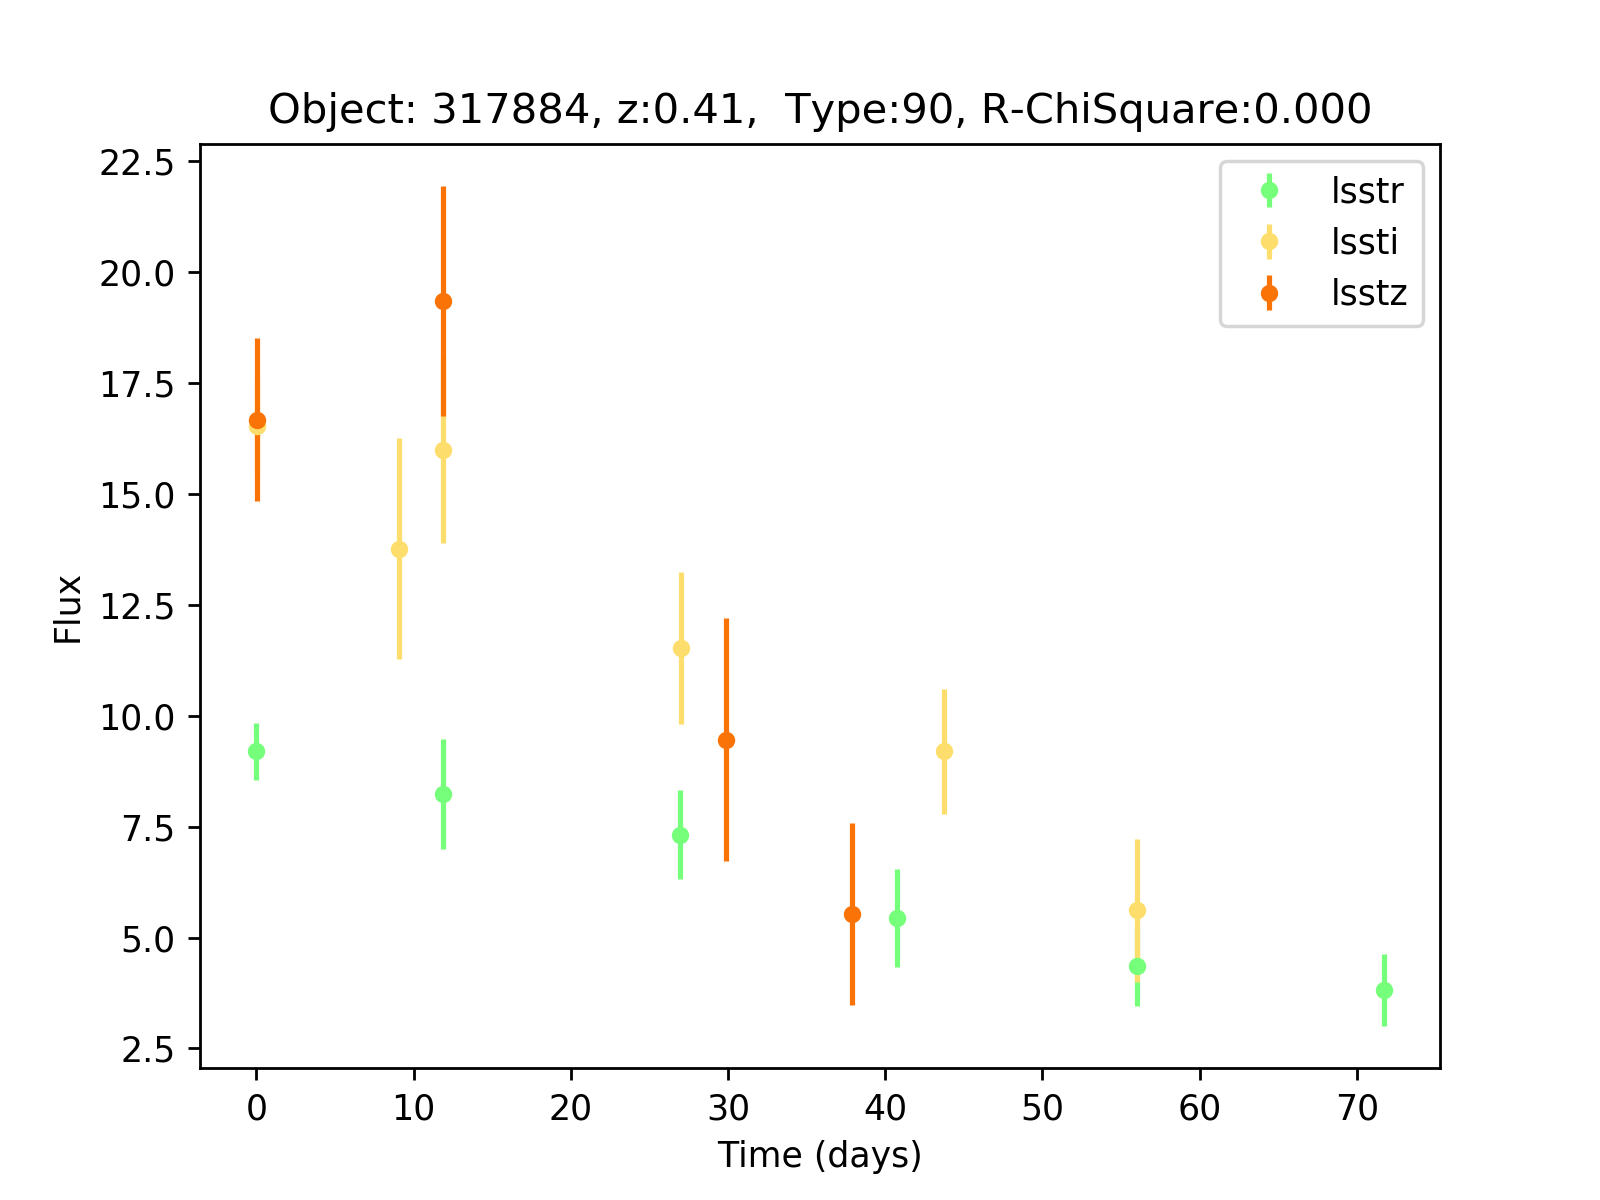

In [12]:
dat.plot_all(mix=True)

Each light curve is represented in the Dataset object as an astropy table, compatible with `sncosmo`:

Note: The types listed here in the table the internal types to snmachine

In [13]:
# dat.data[dat.object_names[0]]

## Extract features for the data

The next step is to extract useful features from the data. This can often take a long time, depending on the feature extraction method, so it's a good idea to save these to file (`snmachine` by default saves to astropy tables)

### Inspect GP fitting capability for individual objects first

In [14]:
# Choose a random object to inspect

# test_obj = dat.object_names[1101]
# print(type(test_obj))
# plt.figure()
# dat.plot_lc(test_obj, plot_model=True)

In [15]:
#sn = dat.data[test_obj]

# g=snfeatures._GP(test_obj, dat,ngp=1100,xmin=0,xmax=dat.get_max_length(),initheta=[500,20], save_output=True, output_root=out_int)
# dat.models[test_obj] = g
# type(dat)
# #dat.plot_lc(test_obj, plot_model=True)
# plt.figure()
# dat.plot_lc(test_obj, plot_model=True)

### Wavelet features

The wavelet feature extraction process is quite complicated, although it is fairly fast. Remember to save the PCA eigenvalues, vectors and mean for later reconstruction!

In [16]:
run_name=os.path.join(out_features,'{}_all'.format(dataset))
pickle_location = rt

read_from_ascii=False #We can use this flag to quickly rerun from saved features
read_from_binary=True
restart_from_GP = False
restart_from_wavefeats=False

In [17]:
#waveFeats=snfeatures.WaveletFeatures()
wavelet_feats=snfeatures.WaveletFeatures(wavelet='sym2', ngp=1100)

In [18]:
#%%capture --no-stdout
if read_from_ascii:
    
    print("Reading from ascii formats...")
    
    wavelet_features=Table.read('%s_wavelets.dat' %run_name, format='ascii')
    #Crucial for this format of id's
    blah=wavelet_features['Object'].astype(str)
    wavelet_features.replace_column('Object', blah)
    vals=np.loadtxt('%s_wavelets_PCA_vals.dat' %run_name)
    vec=np.loadtxt('%s_wavelets_PCA_vec.dat' %run_name)
    means=np.loadtxt('%s_wavelets_PCA_mean.dat' %run_name)
    
elif read_from_binary:
    
    print("Reading from binary formats...")
    
    wavelet_features = Table.read('{}_wavelet_features.fits'.format(run_name))
    vals = np.load('{}_wavelets_PCA_vals.npy'.format(run_name))
    vec  = np.load('{}_wavelets_PCA_vec.npy'.format(run_name))
    means= np.load('{}_wavelets_PCA_mean.npy'.format(run_name))
    
    
#     f = open(rt)
#     wave_features=Table.read('%s_wavelets.dat' %run_name, format='ascii')
#     #Crucial for this format of id's
#     blah=wave_features['Object'].astype(str)
#     wave_features.replace_column('Object', blah)
#     PCA_vals=np.loadtxt('%s_wavelets_PCA_vals.dat' %run_name)
#     PCA_vec=np.loadtxt('%s_wavelets_PCA_vec.dat' %run_name)
#     PCA_mean=np.loadtxt('%s_wavelets_PCA_mean.dat' %run_name)
elif restart_from_GP:
    
    print("Restarting from GPs...")
    
    wavelet_features=wave_feats.extract_features(dat,number_processes=nproc,output_root=rt,save_output='all',restart='gp')
    wavelet_features.write('%s_wavelets.dat' %run_name, format='ascii')
    np.savetxt('%s_wavelets_PCA_vals.dat' %run_name,wave_feats.PCA_eigenvals)
    np.savetxt('%s_wavelets_PCA_vec.dat' %run_name,wave_feats.PCA_eigenvectors)
    np.savetxt('%s_wavelets_PCA_mean.dat' %run_name,wave_feats.PCA_mean)
    
    vals=wave_feats.PCA_eigenvals
    vec=wave_feats.PCA_eigenvectors
    means=wave_feats.PCA_mean
    
# elif restart_from_wavefeats:
    
#     wave_features=Table.read(rt  + 'wavelet_features.fits',format='fits')
#     wave_features.write('%s_wavelets.dat' %run_name, format='ascii')
#     f = open(rt+'PCA_eigenvals.pickle','rb')
#     PCA_vals=pickle.load(f)
#     f.close()
#     f = open(rt+'PCA_eigenvectors.pickle','rb')
#     PCA_vec=pickle.load(f)
#     f.close()
#     f = open(rt+'PCA_mean.pickle','rb')
#     PCA_mean=pickle.load(f)
#     f.close()
#     np.savetxt('%s_wavelets_PCA_vals.dat' %run_name,PCA_vals)
#     np.savetxt('%s_wavelets_PCA_vec.dat' %run_name,PCA_vec)
#     np.savetxt('%s_wavelets_PCA_mean.dat' %run_name,PCA_mean)
    
else:
    
    print("Starting from scratch ...")
    wavelet_features=wavelet_feats.extract_features(dat,number_processes=nproc,output_root=out_int,save_output='all', xmax=1100)
    # Write to ASCII
    wavelet_features.write('%s_wavelets.dat' %run_name, format='ascii')
    np.savetxt('%s_wavelets_PCA_vals.dat' %run_name,wavelet_feats.PCA_eigenvals)
    np.savetxt('%s_wavelets_PCA_vec.dat' %run_name,wavelet_feats.PCA_eigenvectors)
    np.savetxt('%s_wavelets_PCA_mean.dat' %run_name,wavelet_feats.PCA_mean)
    # Write to binary
    wavelet_features.write('{}_wavelet_features.fits'.format(run_name))
    np.save('{}_wavelets_PCA_vals.npy'.format(run_name),wavelet_feats.PCA_eigenvals)
    np.save('{}_wavelets_PCA_vec.npy'.format(run_name),wavelet_feats.PCA_eigenvectors)
    np.save('{}_wavelets_PCA_mean.npy'.format(run_name),wavelet_feats.PCA_mean)
    
    vals=wavelet_feats.PCA_eigenvals
    vec=wavelet_feats.PCA_eigenvectors
    means=wavelet_feats.PCA_mean

Reading from binary formats...


In [19]:
# wavelet_features.write('{}_wavelet_features.fits'.format(run_name))

In [20]:
# np.save('{}_wavelets_PCA_vec.npy'.format(run_name),vec)
# np.save('{}_wavelets_PCA_vals.npy'.format(run_name),vals)
# np.save('{}_wavelets_PCA_mean.npy'.format(run_name),means)

In [21]:
#dat.set_model(waveFeats.fit_sn,wave_features,PCA_vec,PCA_mean,0,dat.get_max_length(),dat.filter_set)
# dat.set_model(wavelet_feats.fit_sn,wavelet_features,vec,means,0,dat.get_max_length(),dat.filter_set)

In [22]:
# dat.plot_all(mix=True)

### Chi Squared Histogram

We want to double check the GP's have been fit well.

In [23]:
# training_objects = list(dat.object_names[:1])
# training_objects

In [24]:
# lc = dat.data['190161']
# lc

In [25]:
# chi_dict_test_obj = dat.reduced_chi_squared(training_objects)[training_objects[0]]
# chi_dict_test_obj

In [26]:
# plt.figure(99)
# plt.hist(chi_dict.values(), bins=1000, range=(0.0, 100))
# plt.show()

In [27]:
# Get the types, note these are internal snmachine datatypes
types=dat.get_types()
d = dat.dict_2_user_types
d = {int(k):int(v) for k,v in d.items()}
typespd = types.to_pandas()
typespd.head()

,Object,Type
0,50875482,8
1,46567,5
2,317884,3
3,64379782,2
4,268605,10


In [31]:
# Remap snmachine int types to the class labels
newcol = typespd.Type.map(d)
typespd.update(newcol)
types = Table.from_pandas(typespd)
types[:15]

Object,Type
str9,float64
50875482,62.0
46567,16.0
317884,90.0
64379782,42.0
268605,52.0
84448602,92.0
288194,53.0
170883,65.0
15968,90.0


Restarting from stored Gaussian Processes...


<IPython.core.display.Javascript object>


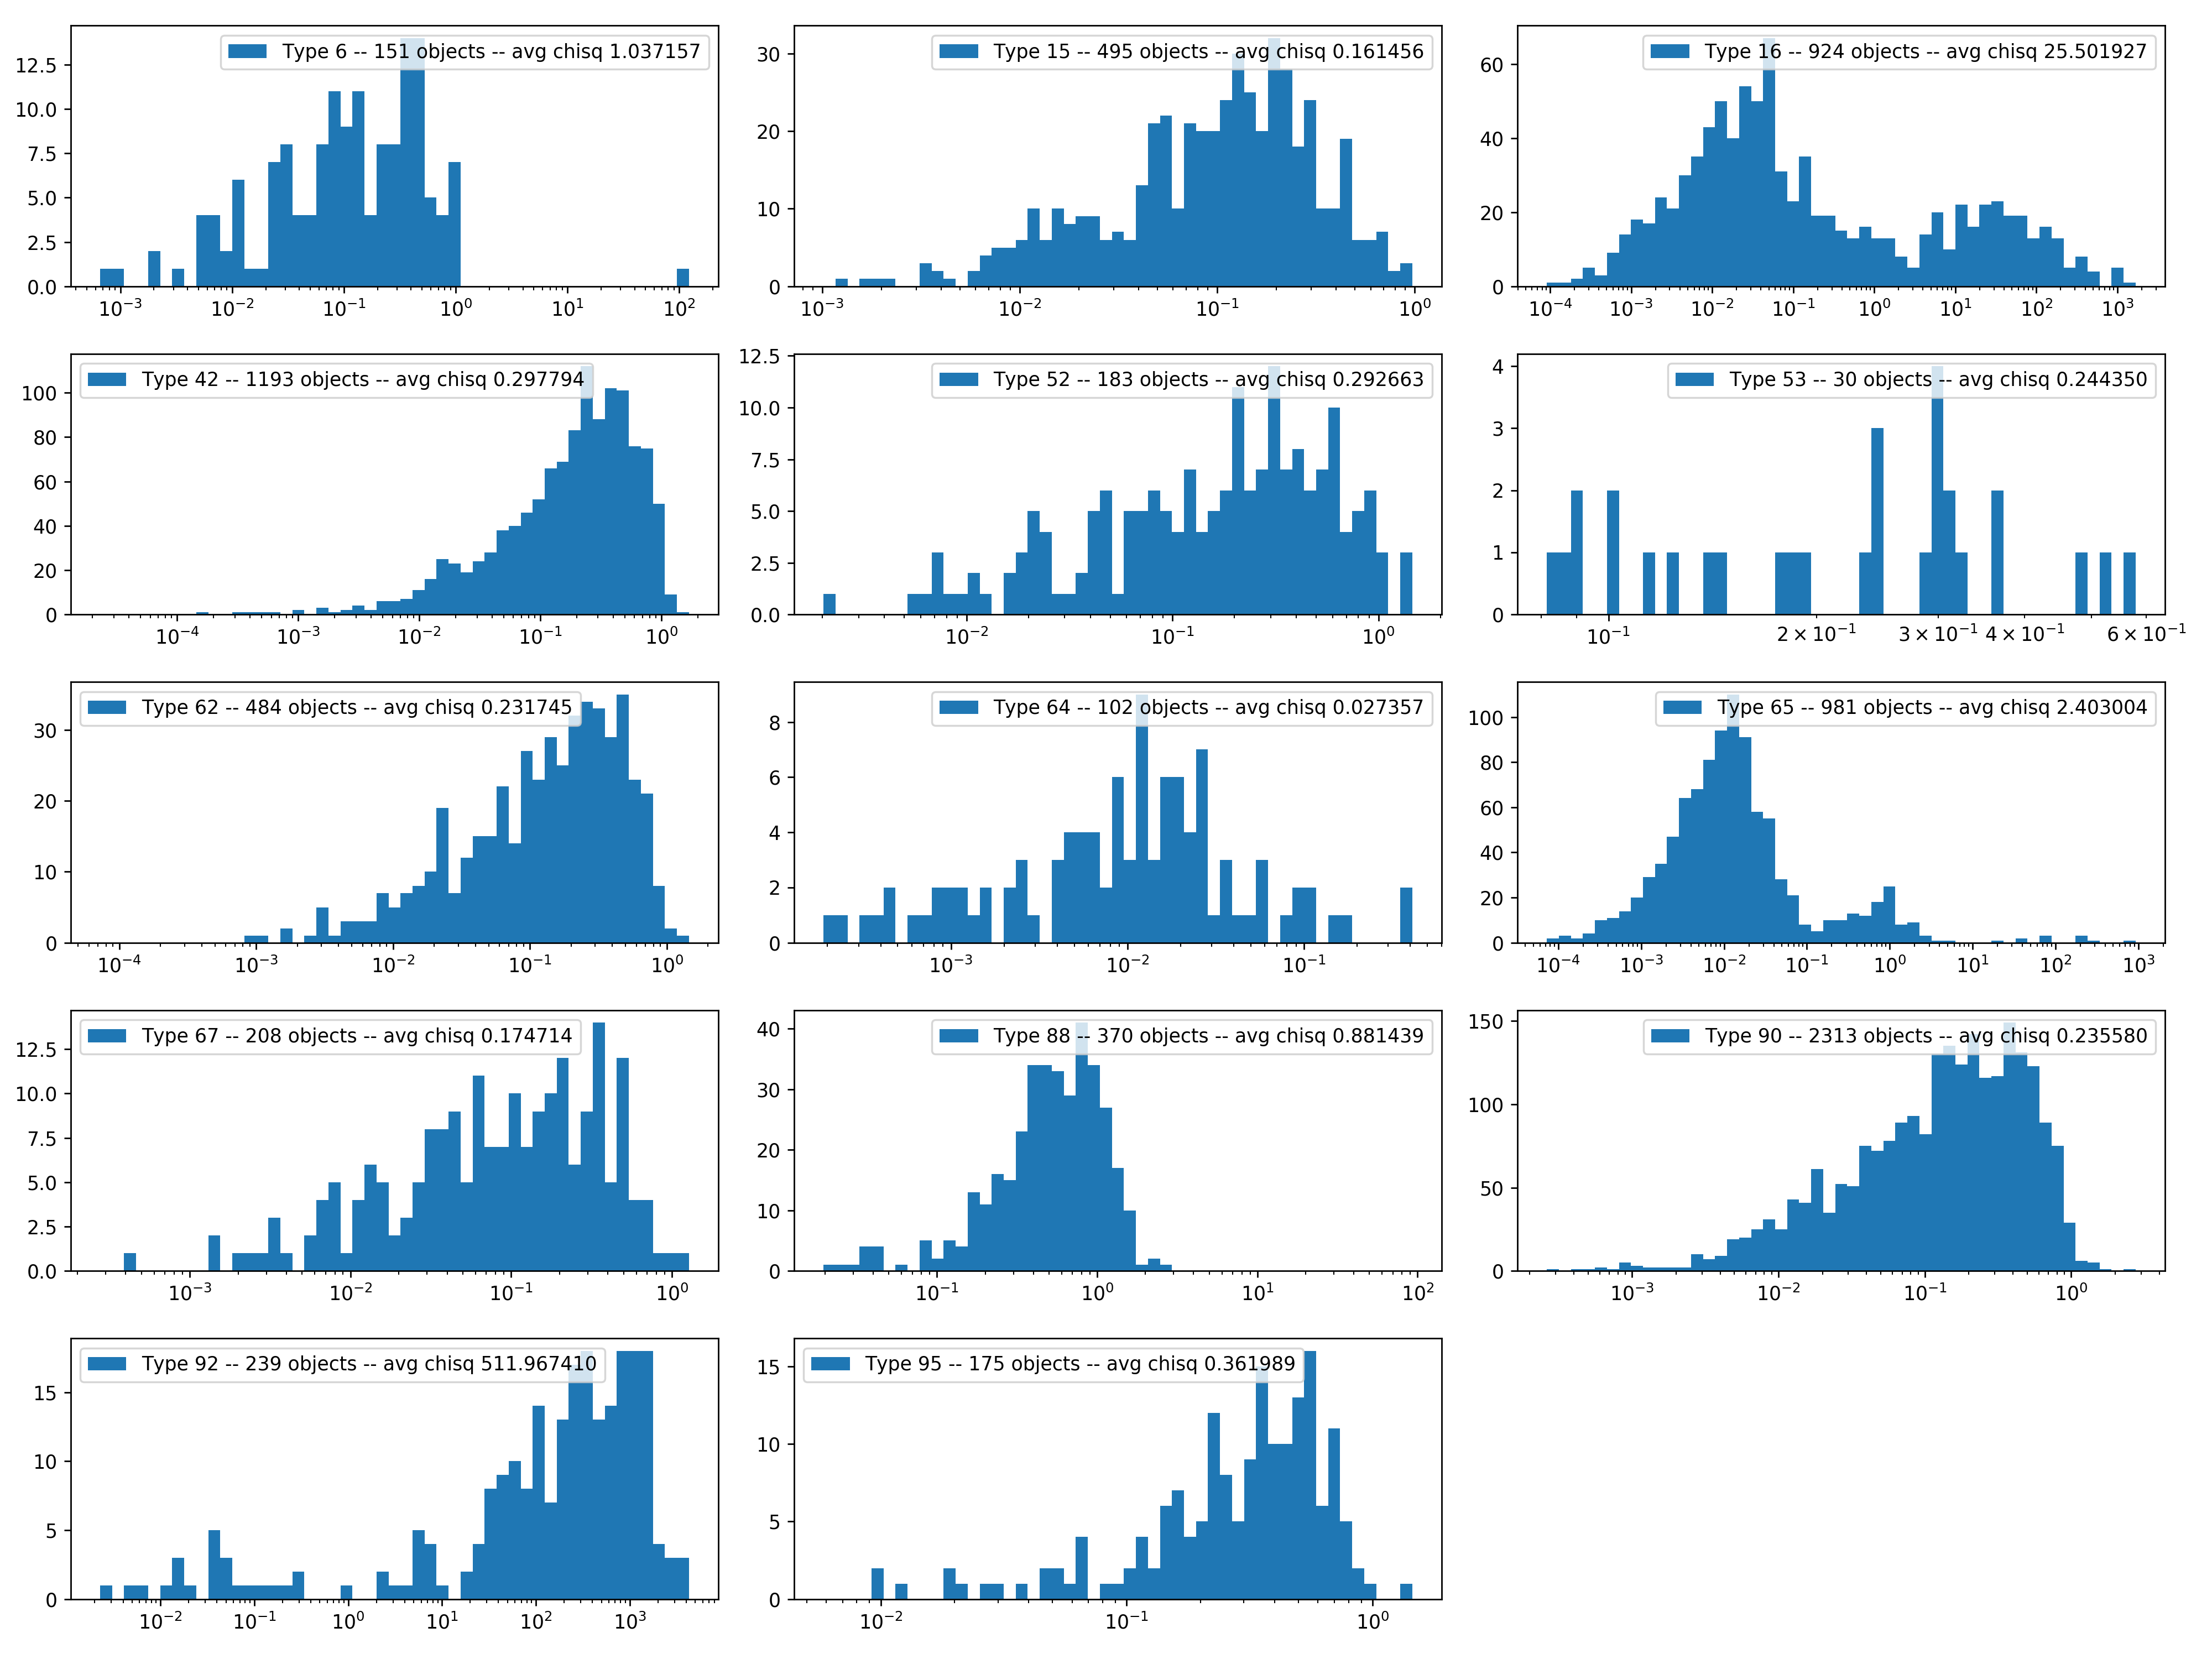

In [29]:
#create features object and read in fitted GPs
wf=snfeatures.WaveletFeatures(wavelet='sym2', ngp=1100)
wf.restart_from_gp(dat,output_root=out_int+'/')

#compute chi2/dof for all objects (summarising all bands into one value)
chisq=dat.reduced_chi_squared()

#divide chisq values by type
# types=dat.get_types()
unique_types=np.unique(types['Type'])
objs_by_types={}
for t in unique_types:
        tlist=types['Object'][types['Type']==t]
        objs_by_types[t]=tlist

#define auxiliary routine that sets up the histogram for each plot
def makeplot(t,ax):
        chisq_t=np.array([chisq[o] for o in objs_by_types[t]])
        mini,maxi=chisq_t.min(),chisq_t.max()
        ax.set_xscale('log')
        ax.hist(chisq_t,bins=np.logspace(np.log10(mini),np.log10(maxi),50),label='Type %s -- %d objects -- avg chisq %f'%(str(t),len(chisq_t), chisq_t.mean()))
        ax.legend()

#plot histograms for each type
fig,axes=plt.subplots(nrows=5,ncols=3,figsize=(16,12))
for i in range(len(unique_types)):
        ax=axes.flatten()[i]
        makeplot(unique_types[i],ax)

#remove last (empty) plot
axes.flatten()[-1].axis('off')
plt.tight_layout()
plt.show()
plt.savefig(out_plots+'/chisq_by_type.png')

<IPython.core.display.Javascript object>


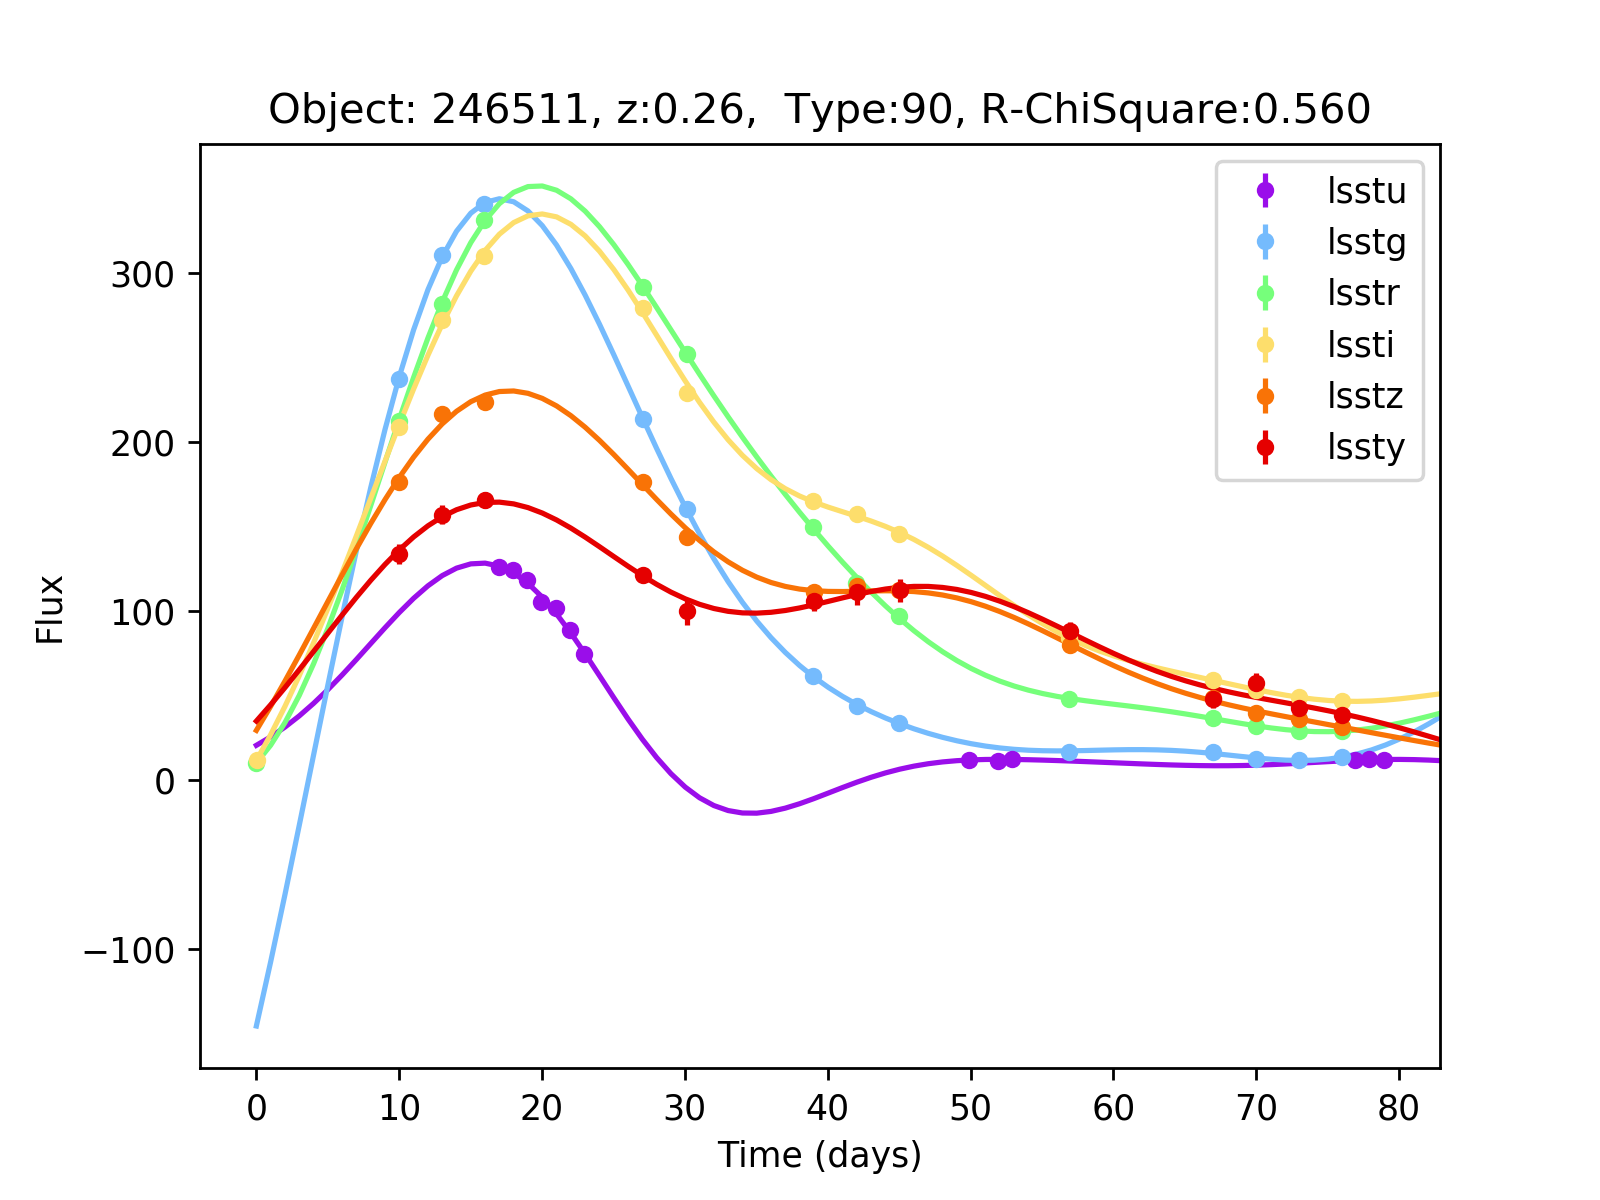

In [30]:
dat.plot_all(mix=True)

In [43]:
chi_obj = ['70665843']
chi_obj
chi_2_single_object = dat.reduced_chi_squared(chi_obj)[chi_obj[0]]
chi_2_single_object

0.076869178096421367

### Plot t-SNE

In [30]:
# plt.figure()
# tsne_plot.plot(wavelet_features,join(wave_features,types)['Type'], type_dict=dat.dict_2_user_types)

## Classify

Finally, we're ready to run the machine learning algorithm. There's a utility function in the `snclassifier` library to make it easy to run all the algorithms available, including converting features to `numpy` arrays and rescaling them and automatically generating ROC curves and metrics. Hyperparameters are automatically selected using a grid search combined with cross-validation. All functionality can also be individually run from `snclassifier`.

Classifiers can be run in parallel, change this parameter to the number of processors on your machine (we're only running 4 algorithms so it won't help to set this any higher than 4).

In [31]:
#Available classifiers 
print(snclassifier.choice_of_classifiers)

['svm', 'knn', 'random_forest', 'decision_tree', 'boost_dt', 'boost_rf', 'nb', 'neural_network']


In [279]:
# Drop Object column, implement a conditional for this
# wfdf = wavelet_features.to_pandas()
# wfdf = wfdf.drop('Object', axis=1)
# wavelet_features = Table.from_pandas(wfdf)
wavelet_features

Object,C0,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36,C37,C38,C39,C40,C41,C42,C43,C44,C45,C46,C47,C48,C49,C50,C51,C52,C53,C54,C55,C56,C57,C58,C59,C60,C61,C62,C63,C64,C65,C66,C67,C68,C69,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86,C87,C88,C89,C90,C91,C92,C93,C94,C95,C96,C97,C98,C99,C100,C101,C102,C103,C104,C105,C106,C107,C108,C109,C110,C111,C112,C113,C114,C115,C116,C117,C118,C119,C120,C121,C122,C123,C124,C125,C126,C127,C128,C129,C130,C131,C132,C133,C134,C135,C136,C137,C138,C139,C140,C141,C142,C143,C144,C145,C146,C147,C148,C149,C150,C151,C152,C153,C154,C155,C156,C157,C158,C159,C160,C161,C162,C163,C164,C165,C166,C167,C168,C169,C170,C171,C172,C173,C174,C175,C176,C177,C178,C179,C180,C181,C182,C183,C184,C185,C186,C187,C188,C189,C190,C191,C192,C193,C194,C195,C196,C197,C198,C199,C200,C201,C202,C203,C204,C205,C206,C207,C208,C209
bytes21,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
61866802,-3838.6659088,-23.3702885407,389.53140277,-447.338995169,198.764095761,4883.27066542,-1576.37801826,831.261127819,3064.52928468,149.776934435,-1257.61674965,-253.695699932,204.779773691,1082.09835914,-94.7587377385,-164.401780968,162.054276409,34.9512512671,-599.167720093,-34.5285605494,32.5631486152,750.435938539,136.595080765,-366.492106459,-247.671054477,50.7275297627,225.183432249,20.68519741,-221.108727382,-220.32694467,-186.73466485,-88.0719583701,-121.171801583,-12.2797157483,80.8646564231,-23.7163234259,155.400744319,-27.9669520714,-192.684442108,-68.3959055726,8.56232531642,-38.6134160326,99.3944722633,24.4171390505,-32.2025476508,9.69040348683,-90.5880642013,16.4770884379,-15.7411673315,122.883440218,28.4567532168,-178.54555895,-30.1001972547,39.3015728563,24.2793347507,42.9840745423,46.9959306683,-48.6912133145,-42.5086675038,32.1323343433,-75.7646899627,22.2018676249,24.5463313728,1.48573067493,17.4444692801,-20.1185603937,-1.69176809398,32.2914027056,41.4635981364,3.97519608696,87.8669189221,-55.2449661908,27.3742338934,-16.2978078257,41.1524484528,-29.1641021506,24.5837356596,29.6059396488,4.23896086862,9.64707752604,32.5685238206,-3.67058896695,22.0182437727,-23.3795489321,-4.88735752837,42.7690934103,12.6647863787,17.9078605831,21.4866564278,-42.8718431107,-12.7814083454,20.2230974833,-24.0442722706,3.0216540065,0.9144

In [280]:
types=dat.get_types()

In [281]:
training_set = list(dat.object_names[:5886])
test_set = list(dat.object_names[5886:])

<IPython.core.display.Javascript object>


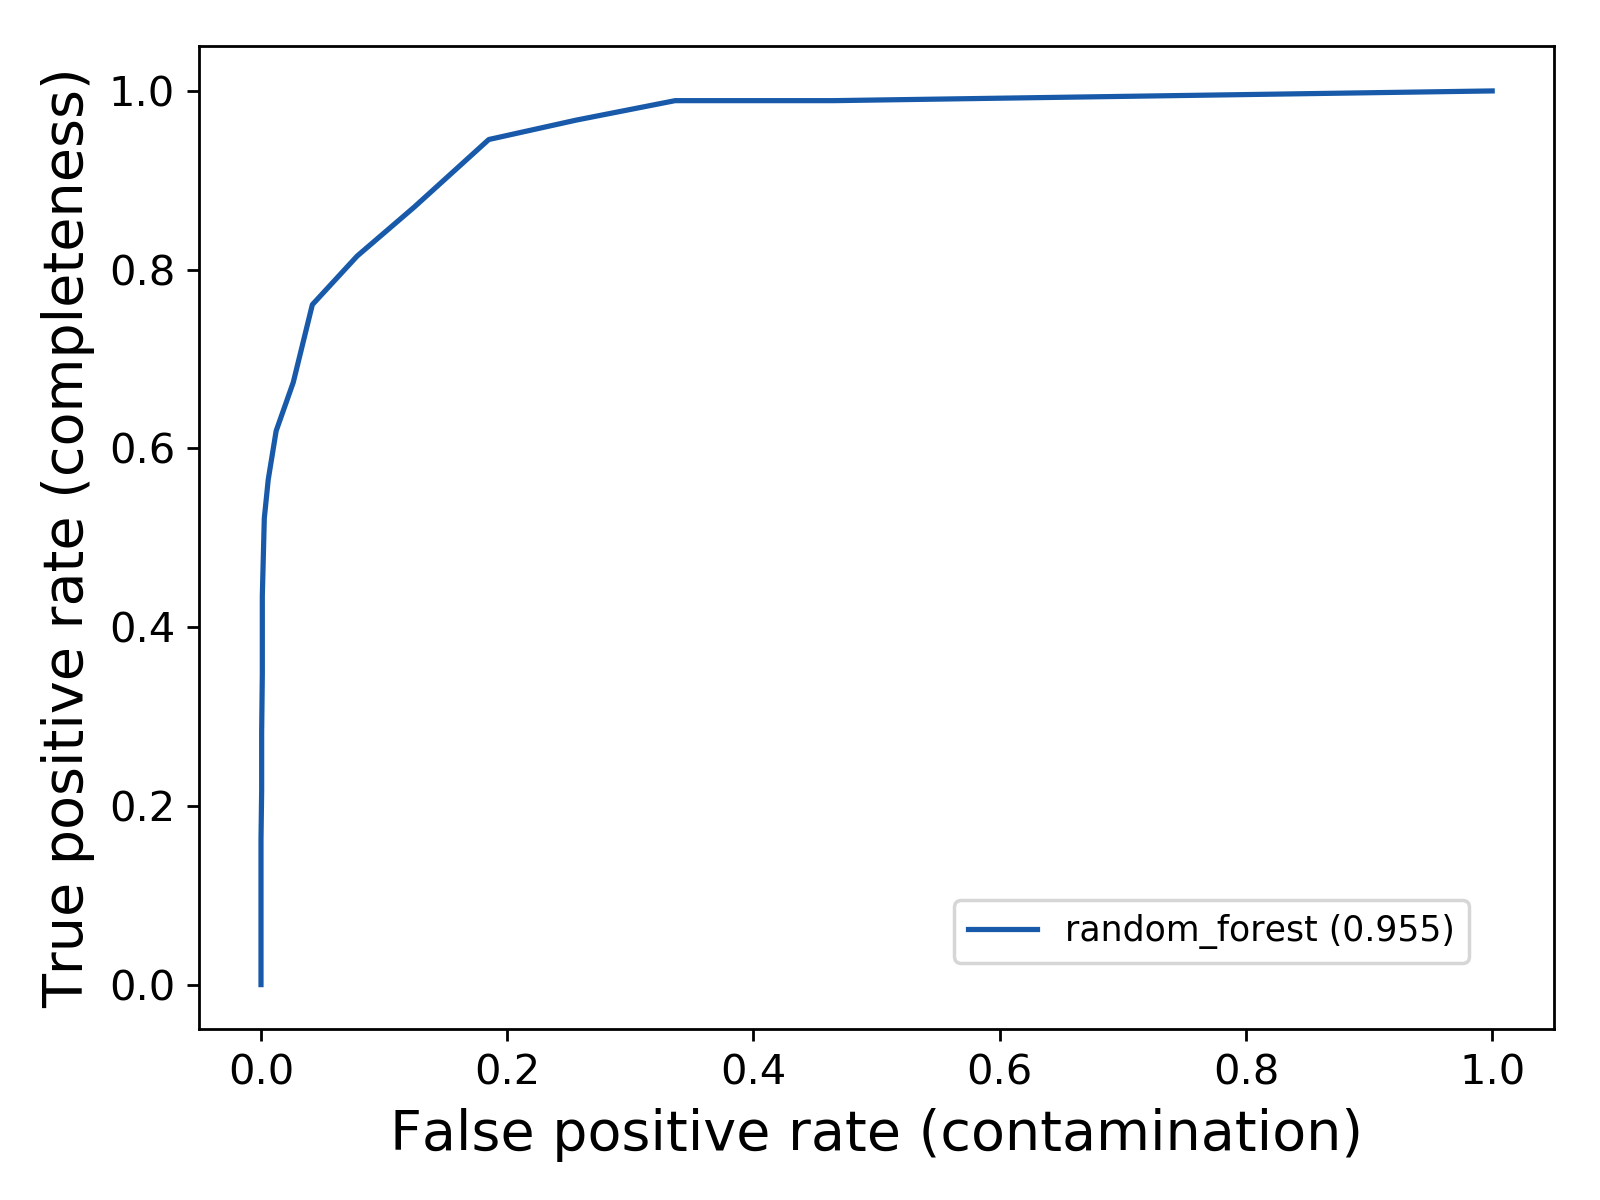

Due to limitations with python's multiprocessing module, classifier objects cannot be returned if multiple processors are used. Continuing serially...

Created classifier of type:
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Optimised parameters: {'criterion': 'entropy', 'n_estimators': 400}
Classifier random_forest: AUC = 0.955257498256 FoM = 0.39751552795

Time taken  154.90769045352937 minutes


/home/tallam/.conda/envs/snmplasticc/lib/python3.6/site-packages/snmachine/snclassifier.py:130: MatplotlibDeprecationWarning: The set_color_cycle function was deprecated in version 1.5. Use `.set_prop_cycle` instead.
  ax.set_color_cycle(cols)


In [282]:
fig = plt.figure()
clss, cms=snclassifier.run_pipeline(wavelet_features,types,output_name=os.path.join(out_class,'wavelets'),
                          training_set=training_set, classifiers=['random_forest'], number_processes=nproc, 
                            return_classifier=True, classifiers_for_cm_plots='all')

In [285]:
import seaborn as sns
from astropy.table import Table,join,unique

<IPython.core.display.Javascript object>


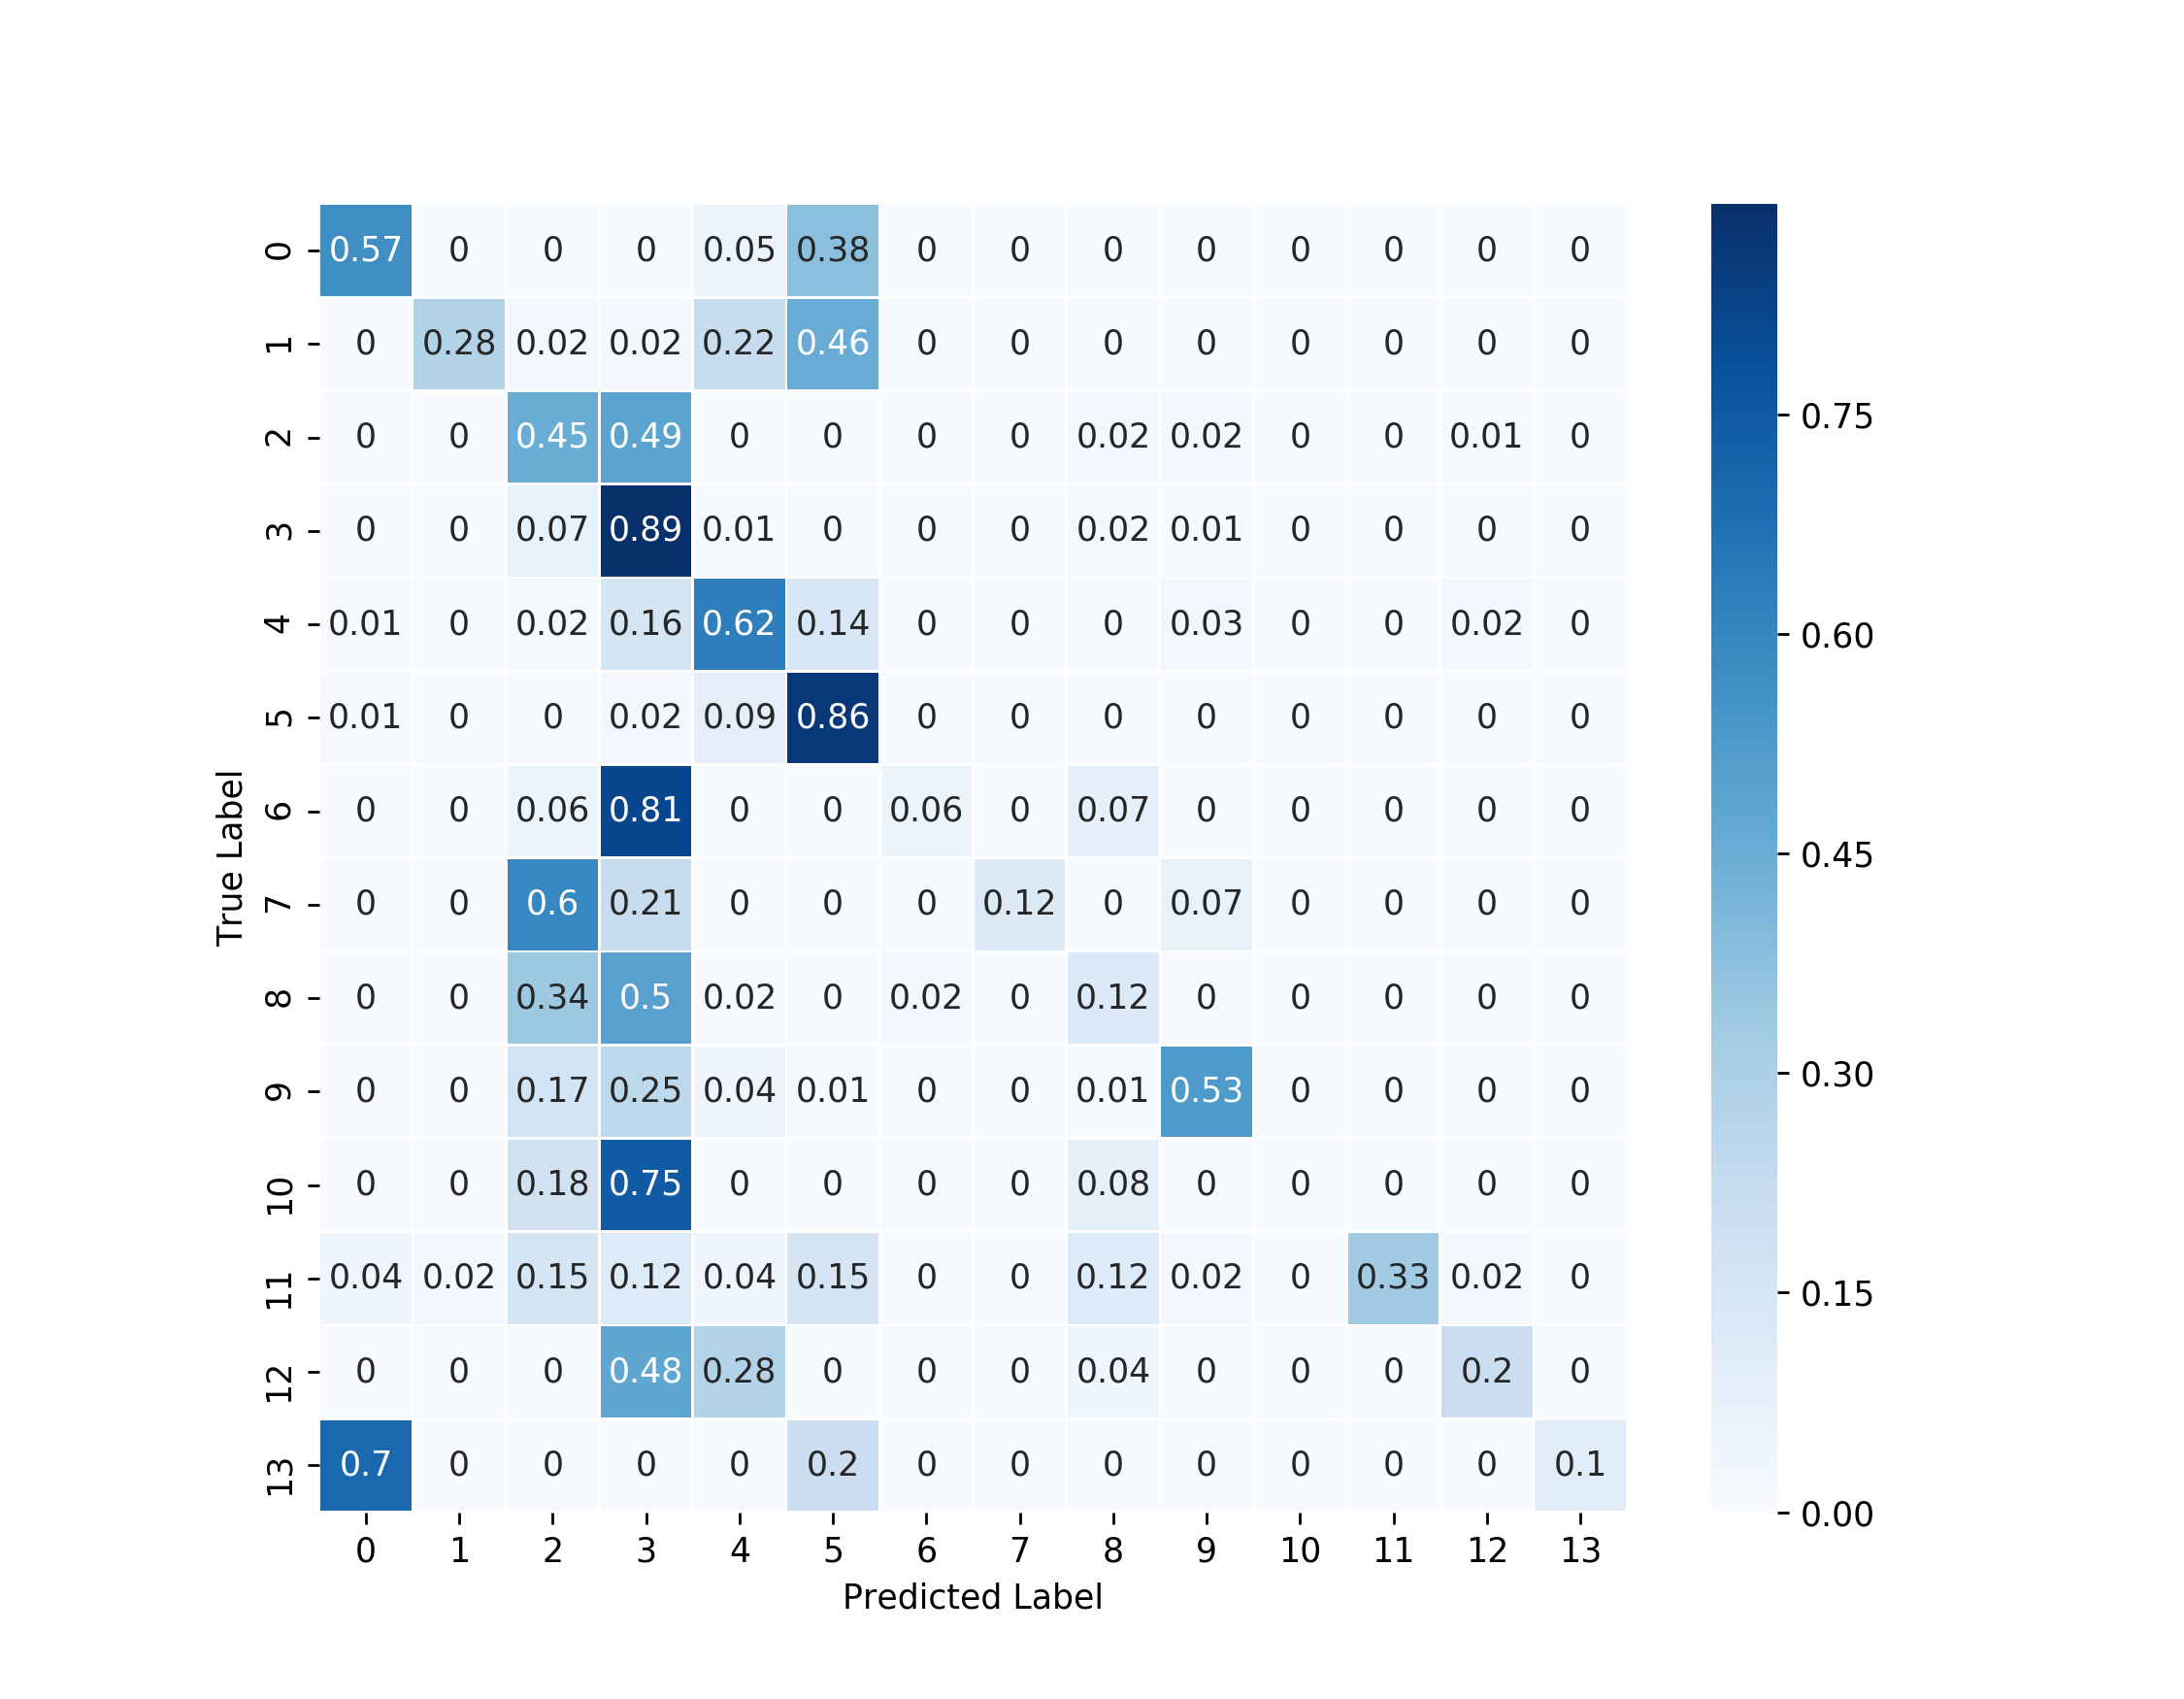

In [286]:
cm = cms[0]
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
annot = np.around(cm, 2)

labels=[]
for tp_row in unique(types, keys='Type'):
    labels.append(tp_row['Type'])
# for item in dat.dict_2_user_types.values():
#     labels.append(item) 

fig, ax = plt.subplots(figsize=(9,7))
sns.heatmap(cm, xticklabels=labels, yticklabels=labels, cmap='Blues', annot=annot, lw=0.5)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_aspect('equal')

##### TODO
* Combine further features
* Apply oversampling techniques
* Compare confusion matrices from before

In [287]:
wavelet_features.to_pandas().head()

,Object,C0,C1,C2,C3,C4,C5,C6,C7,C8,...,C200,C201,C202,C203,C204,C205,C206,C207,C208,C209
0,b'61866802',-3838.665909,-23.370289,389.531403,-447.338995,198.764096,4883.270665,-1576.378018,831.261128,3064.529285,...,3.546079,-1.593200,7.665127,-13.890665,-2.961275,6.994729,-2.080307,5.435183,0.984619,-0.363728
1,b'90534',-6054.300643,634.789560,-67.849535,153.342589,180.646430,18.684683,216.022956,75.440973,-150.804505,...,-0.901112,0.140268,0.172928,1.683506,0.005992,-0.892394,2.308500,-2.188821,-0.853802,-0.420427
2,b'157477',26494.242089,-26402.617040,167.616957,-1959.565326,11042.785667,1788.822997,15848.027267,-2632.649881,3625.427106,...,-107.244414,-143.545190,-5.416159,90.586282,56.713768,-18.727096,61.364676,154.580311,61.552865,63.085322
3,b'42802824',11114.194541,-16116.107840,-1144.901835,-3677.814505,1338.870793,1010.247368,7204.349231,-4527.188144,4359.823073,...,72.911762,-192.184578,57.090222,-30.566860,-29.118312,-1.422281,-71.553583,-85.429854,69.806713,-103.860481
4,b'103802998',-2853.326475,-3227.369546,-176.068106,-121.816349,616.694605,229.369035,-411.982730,755.843925,-1026.188102,...,-13.697440,17.991907,9.668667,-15.498821,-56.024476,-4.929189,38.823685,13.527556,-5.300636,-35.195323


In [288]:
trainFeatures = wavelet_features.to_pandas()
#trainFeatures = Table.read('/share/hypatia/snmachine_resources/data/plasticc/data_products/plasticc_training/without_seasongap_cutting/features/wavelet_features.fits').to_pandas()
trainMeta = pd.read_csv('/share/hypatia/snmachine_resources/data/plasticc/training_set_metadata.csv', header=0, delimiter=',')
targetNames = trainMeta['target'].unique() # np.array with the names of the targets (only 14)

X = trainFeatures.drop('Object', axis=1)
#X = trainFeatures
y = trainMeta['target'].values

In [289]:
X.head()

,C0,C1,C2,C3,C4,C5,C6,C7,C8,C9,...,C200,C201,C202,C203,C204,C205,C206,C207,C208,C209
0,-3838.665909,-23.370289,389.531403,-447.338995,198.764096,4883.270665,-1576.378018,831.261128,3064.529285,149.776934,...,3.546079,-1.593200,7.665127,-13.890665,-2.961275,6.994729,-2.080307,5.435183,0.984619,-0.363728
1,-6054.300643,634.789560,-67.849535,153.342589,180.646430,18.684683,216.022956,75.440973,-150.804505,214.518882,...,-0.901112,0.140268,0.172928,1.683506,0.005992,-0.892394,2.308500,-2.188821,-0.853802,-0.420427
2,26494.242089,-26402.617040,167.616957,-1959.565326,11042.785667,1788.822997,15848.027267,-2632.649881,3625.427106,-848.443646,...,-107.244414,-143.545190,-5.416159,90.586282,56.713768,-18.727096,61.364676,154.580311,61.552865,63.085322
3,11114.194541,-16116.107840,-1144.901835,-3677.814505,1338.870793,1010.247368,7204.349231,-4527.188144,4359.823073,-3845.589325,...,72.911762,-192.184578,57.090222,-30.566860,-29.118312,-1.422281,-71.553583,-85.429854,69.806713,-103.860481
4,-2853.326475,-3227.369546,-176.068106,-121.816349,616.694605,229.369035,-411.982730,755.843925,-1026.188102,-69.167892,...,-13.697440,17.991907,9.668667,-15.498821,-56.024476,-4.929189,38.823685,13.527556,-5.300636,-35.195323


In [290]:
print(type(X), type(y))
print(X.shape, y.shape)

<class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>
(7848, 210) (7848,)


### Oversample using `imbalance-learn`

In [291]:
# Authors: Guillaume Lemaitre <g.lemaitre58@gmail.com>
# License: MIT

from collections import Counter

from sklearn.datasets import load_iris
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import auc, roc_curve, confusion_matrix

from imblearn.datasets import make_imbalance
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.over_sampling import SVMSMOTE, SMOTENC, ADASYN
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.pipeline import make_pipeline
from imblearn.metrics import classification_report_imbalanced
from sklearn.model_selection import KFold

In [292]:
RANDOM_STATE = 42

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=RANDOM_STATE)

print('Training target statistics: {}'.format(Counter(y_train)))
print("")
print('Testing target statistics: {}'.format(Counter(y_test)))

rf = RandomForestClassifier(n_estimators=700, criterion='entropy',\
                             oob_score=True, n_jobs=-1, random_state=RANDOM_STATE)

# Create a pipeline
# SMOTE - 1.6
# SMOTETomek - 1.6
# SMOTENC - 1.7, very slow -- categorical_features=list(np.unique(y))
# SVMSMOTE - 1.8

pipeline = make_pipeline(SMOTETomek(sampling_strategy='all'),rf)

pipeline.fit(X_train, y_train)

# Classify and report the results
print(classification_report_imbalanced(y_test, pipeline.predict(X_test)))

Training target statistics: Counter({90: 1730, 42: 893, 65: 738, 16: 692, 15: 374, 62: 372, 88: 268, 92: 185, 67: 162, 52: 132, 95: 126, 6: 116, 64: 80, 53: 18})

Testing target statistics: Counter({90: 583, 42: 300, 65: 243, 16: 232, 15: 121, 62: 112, 88: 102, 92: 54, 52: 51, 95: 49, 67: 46, 6: 35, 64: 22, 53: 12})
                   pre       rec       spe        f1       geo       iba       sup

          6       0.03      0.03      0.99      0.03      0.17      0.03        35
         15       0.07      0.05      0.95      0.06      0.22      0.04       121
         16       0.14      0.12      0.90      0.13      0.34      0.10       232
         42       0.16      0.13      0.88      0.14      0.33      0.10       300
         52       0.00      0.00      0.98      0.00      0.00      0.00        51
         53       0.00      0.00      1.00      0.00      0.00      0.00        12
         62       0.03      0.03      0.95      0.03      0.16      0.02       112
         64      

/home/tallam/.conda/envs/snmplasticc/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [293]:
print(list(pipeline.named_steps.items())[0][0])

smotetomek


In [294]:
print('Original dataset shape (%s, %s)' % X.shape)
print('Original dataset samples per class {}'.format(Counter(y)))
print("")
print(pipeline.steps[0][1])
X_res, y_res = pipeline.steps[0][1].fit_resample(X, y)
print('Resampled dataset samples per class {}'.format(Counter(y_res)))

Original dataset shape (7848, 210)
Original dataset samples per class Counter({90: 2313, 42: 1193, 65: 981, 16: 924, 15: 495, 62: 484, 88: 370, 92: 239, 67: 208, 52: 183, 95: 175, 6: 151, 64: 102, 53: 30})

SMOTETomek(random_state=None, ratio=None, sampling_strategy='all', smote=None,
      tomek=None)
Resampled dataset samples per class Counter({53: 2313, 6: 2307, 64: 2303, 52: 2301, 67: 2298, 92: 2297, 88: 2293, 95: 2290, 62: 2284, 15: 2284, 16: 2261, 65: 2242, 42: 2229, 90: 2198})


In [295]:
y_preds = pipeline.predict(X_test)

In [296]:
def plotConfusionMatrix(yTrue, yPredict, dataName):
    cm = confusion_matrix(yTrue, yPredict, labels=targetNames)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    annot = np.around(cm, 2)

    fig, ax = plt.subplots(figsize=(9,7))
    sns.heatmap(cm, xticklabels=targetNames, yticklabels=targetNames, cmap='Blues', annot=annot, lw=0.5)
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    ax.set_aspect('equal')
    plt.title(dataName)
    
    return cm

<IPython.core.display.Javascript object>


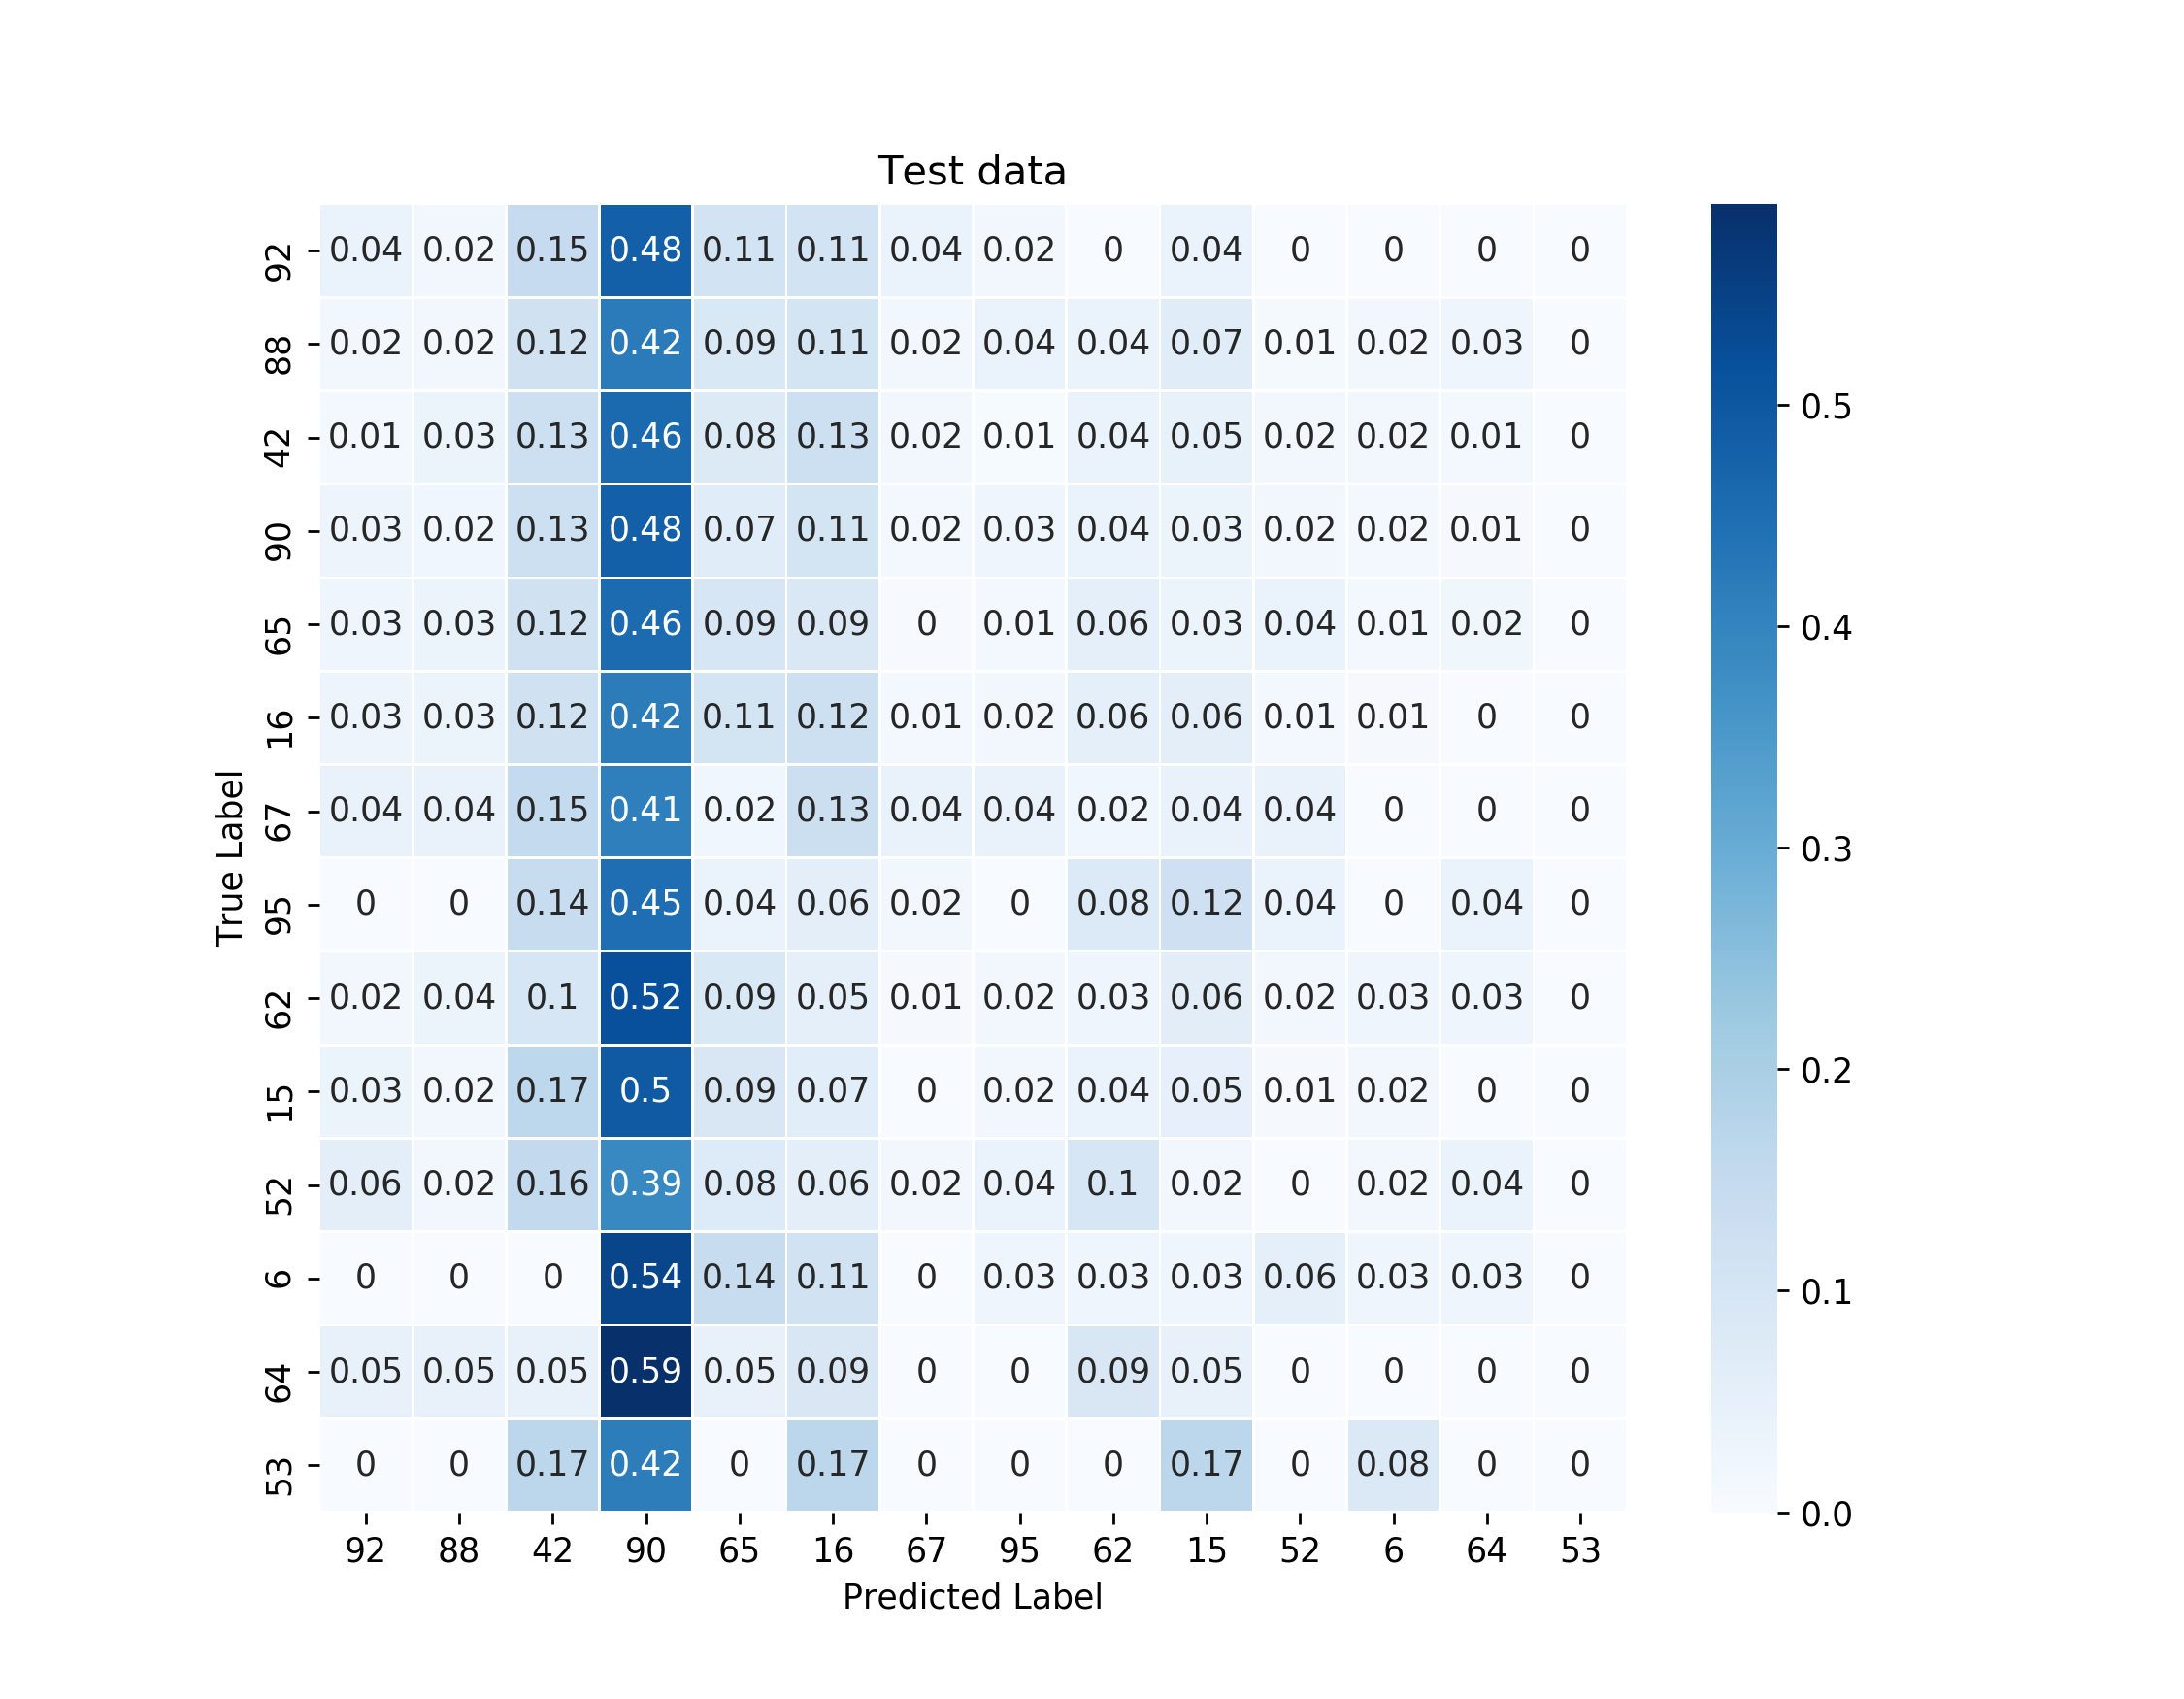

In [297]:
confm = plotConfusionMatrix(y_test, y_preds, 'Test data')

In [298]:
y_probs = pipeline.predict_proba(X_test)

In [299]:
nlines = len(targetNames)
# we also need to express the truth table as a matrix
sklearn_truth = np.zeros((len(y_test), nlines))
label_index_map = dict(zip(pipeline.classes_, np.arange(nlines)))
for i, x in enumerate(y_test):
    sklearn_truth[i][label_index_map[y_test[i]]] = 1

In [300]:
# %load ../snmachine/utils/plasticc_utils.py
"""
Utility script for calculating the log loss
"""

import sys
import numpy as np

def plasticc_log_loss(y_true, y_pred, relative_class_weights=None):
    """
    Implementation of weighted log loss used for the Kaggle challenge
    """
    predictions = y_pred.copy()

    # sanitize predictions
    epsilon = sys.float_info.epsilon # this is machine dependent but essentially prevents log(0)
    predictions = np.clip(predictions, epsilon, 1.0 - epsilon)
    predictions = predictions / np.sum(predictions, axis=1)[:, np.newaxis]

    predictions = np.log(predictions)
    # multiplying the arrays is equivalent to a truth mask as y_true only contains zeros and ones
    class_logloss = []
    for i in range(predictions.shape[1]):
        # average column wise log loss with truth mask applied
        result = np.average(predictions[:, i][y_true[:, i] == 1])
        class_logloss.append(result)
    return -1 * np.average(class_logloss, weights=relative_class_weights)

weights = np.array([1/18, 1/9, 1/18, 1/18, 1/18, 1/18, 1/18, 1/9, 1/18, 1/18, 1/18, 1/18, 1/18, 1/18, 1/19])

In [301]:
logloss = plasticc_log_loss(sklearn_truth, y_probs, relative_class_weights=weights[:-1])
print("LogLoss: {:.3f}\nBest Params: {}".format(logloss, pipeline.get_params))

LogLoss: 3.038
Best Params: <bound method Pipeline.get_params of Pipeline(memory=None,
     steps=[('smotetomek', SMOTETomek(random_state=None, ratio=None, sampling_strategy='all', smote=None,
      tomek=None)), ('randomforestclassifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
   ...timators=700, n_jobs=-1,
            oob_score=True, random_state=42, verbose=0, warm_start=False))])>
